In [6]:
print('Hello, World!')

Hello, World!


In [16]:
import numpy as np

# -----------------------------
# Game board rules
# -----------------------------
snakes = {16:6,47:26,49:11,56:53,62:19,64:60,87:24,93:73,95:75,98:78}
ladders = {1:38,4:14,9:31,21:42,28:84,36:44,51:67,71:91,80:100}
warp = {**snakes, **ladders}

N = 100   # final absorbing state is 100

# -----------------------------
# Movement with bounce rule
# -----------------------------
def move(i, r):
    j = i + r
    if j > 100:
        j = j - 100                 # your rule
    if j in warp:
        j = warp[j]                 # snake or ladder
    return j

# -----------------------------
# Build P as 101×101 matrix 
# States are 0,1,2,...,100
# -----------------------------
P = np.zeros((N+1, N+1))

for i in range(0, 101):

    # absorbing state
    if i == 100:
        P[i, i] = 1.0
        continue

    # transient state: equal chance of rolling 1..6
    for r in range(1, 7):
        j = move(i, r)
        P[i, j] += 1/6.0

# -----------------------------
# Extract Q = transitions among transient states 0..99
# Q is 100×100
# -----------------------------
Q = P[0:100, 0:100]

# -----------------------------
# Fundamental matrix N = (I - Q)^(-1)
# -----------------------------
I = np.eye(Q.shape[0])
Nmat = np.linalg.inv(I - Q)

# -----------------------------
# Expected times vector: t = N * 1
# t[i] = expected turns starting from state i
# -----------------------------
ones = np.ones(Q.shape[0])
t = Nmat @ ones

# -----------------------------
# Expected time starting from state 0
# -----------------------------
expected_time_from_0 = t[0]

print("Expected number of turns starting from state 0 =", expected_time_from_0)


Expected number of turns starting from state 0 = 56.308755164156594


In [5]:
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("matrix2.csv", header = None)

In [9]:
P = df.iloc[1:, 1:].to_numpy(dtype=float)
N = 101

E = np.zeros(N)
tol = 1e-10
max_iter = 20000
for k in range(max_iter):
    newE = np.zeros_like(E)
    newE[100] = 0

    for i in range(100):
        newE[i] = 1 + np.dot(P[i], E)

    diff = np.max(np.abs(newE - E))
    if diff < tol:
        E = newE
        break

    E = newE

print(f"\nExpected rolls from start state E(0) = {E[0]: .4f}")


Expected rolls from start state E(0) =  35.8349


In [18]:
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv("matrix1.csv", header = None)

In [16]:
P = df.iloc[1:, 1:].to_numpy(dtype=float)
N = 101

E = np.zeros(N)
tol = 1e-10
max_iter = 20000
for k in range(max_iter):
    newE = np.zeros_like(E)
    newE[100] = 0

    for i in range(100):
        newE[i] = 1 + np.dot(P[i], E)

    diff = np.max(np.abs(newE - E))
    if diff < tol:
        E = newE
        break

    E = newE

print(f"\nExpected rolls from start state E(0) = {E[0]: .4f}")


Expected rolls from start state E(0) =  56.3088



Figure saved as E_i_curve.png


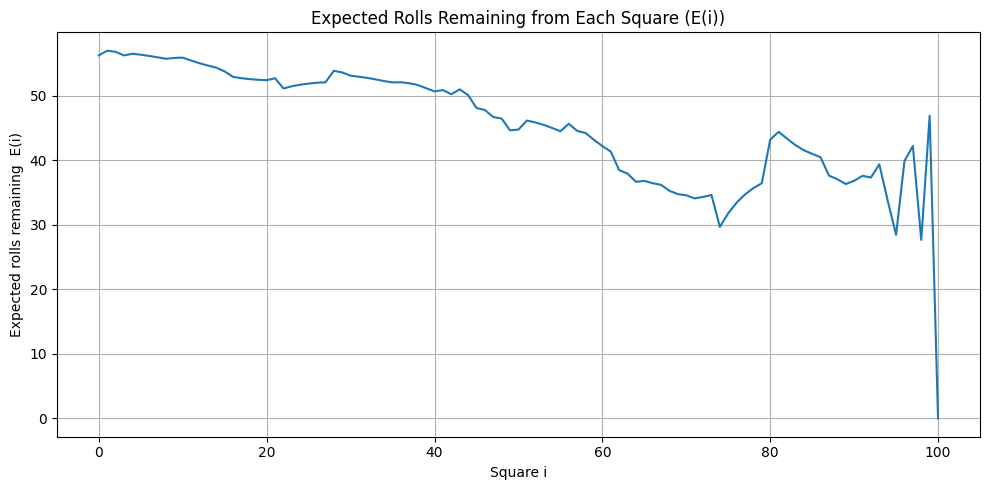

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(N), E)
plt.xlabel("Square i")
plt.ylabel("Expected rolls remaining  E(i)")
plt.title("Expected Rolls Remaining from Each Square (E(i))")
plt.grid(True)
plt.tight_layout()

plt.savefig("E_i_curve.png", dpi=300)
print("\nFigure saved as E_i_curve.png")

plt.show()


In [13]:
import numpy as np

# P is your full 101x101 transition matrix.

# Define absorbing states:
fail_states = [1,2,3,4,5]   # overflow states
success_state = [100]

absorbing = fail_states + success_state
absorbing_set = set(absorbing)

# Transient states = all others
transient = [s for s in range(101) if s not in absorbing_set]

# Build Q and R
Q = P[np.ix_(transient, transient)]
R = P[np.ix_(transient, absorbing)]

# Fundamental matrix
Nmat = np.linalg.inv(np.eye(len(Q)) - Q)

# Absorption probabilities
B = Nmat @ R

# Probability of hitting 100 before overflow
p_success = B[transient.index(0), len(fail_states)]  # column of state 100

print("Probability of hitting 100 on first loop =", p_success)


Probability of hitting 100 on first loop = 0.36916640915058274


In [14]:
import numpy as np

# -----------------------------
# 1. Snakes and ladders
# -----------------------------
snakes = {16:6,47:26,49:11,56:53,62:19,64:60,87:24,93:73,95:75,98:78}
ladders = {1:38,4:14,9:31,21:42,28:84,36:44,51:67,71:91,80:100}

def apply_snakes_ladders(x):
    if x in snakes:
        return snakes[x]
    if x in ladders:
        return ladders[x]
    return x

# ---------------------------------------------------------
# 2. Build the transition matrix P* with an overflow state
# ---------------------------------------------------------
#
# States:
#   0–100 : real board
#   101   : overflow (absorbing "fail")
#
#   100 is absorbing "success"
# ---------------------------------------------------------

N = 102   # 0..100 plus 101 overflow
P = np.zeros((N, N))

for i in range(101):  # states 0..100
    if i == 100:
        # success absorbing state
        P[100,100] = 1.0
        continue

    for r in range(1,7):  # dice roll
        j = i + r

        if j <= 100:
            j2 = apply_snakes_ladders(j)
            P[i, j2] += 1/6
        else:
            # overflow occurs → go to absorbing overflow state 101
            P[i, 101] += 1/6

# overflow absorbing state
P[101,101] = 1.0

# ---------------------------------------------------------
# 3. Compute absorption probabilities: (I - Q)^(-1) R
# ---------------------------------------------------------

transient_states = list(range(100))  # 0..99
absorbing_states = [100, 101]        # success=100, overflow=101

Q = P[np.ix_(transient_states, transient_states)]
R = P[np.ix_(transient_states, absorbing_states)]

I = np.eye(len(Q))
Nmat = np.linalg.inv(I - Q)

B = Nmat @ R  # absorption probabilities

# Probability of hitting 100 before overflow (first loop)
p_success_first_loop = B[0, 0]  # row 0 (start), column 0 (state 100)

print("Probability of hitting 100 on the FIRST LOOP =", p_success_first_loop)


Probability of hitting 100 on the FIRST LOOP = 0.6266110995869417
